In [1]:
import warnings
warnings.filterwarnings("ignore")

import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import Preprocessing as pproc 
import HerdingFunctions as hf
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

In [2]:
# Load data
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')

In [18]:
def unify_location(loc, keep_state=False):
    if not keep_state:
        return 'United States' if loc.startswith('United States') else loc
    else: 
        if loc.startswith('United States'):
            return loc.split(',')[1]
        else: 
            return loc

In [22]:
# Filter the datasets and remove breweries for which the number of beers associated to them is zero
BA_breweries_filt = BA_breweries[BA_breweries['nbr_beers']>=1].copy(deep=True)
RB_breweries_filt = RB_breweries[RB_breweries['nbr_beers']>=1].copy(deep=True)
MB_breweries_filt = MB_breweries[(MB_breweries['nbr_beers']>=1) & (MB_breweries['nbr_beers.1']>=1)].copy(deep=True)

In [23]:
BA_breweries_filt['location'] = BA_breweries_filt['location'].apply(unify_location)
RB_breweries_filt['location'] = RB_breweries_filt['location'].apply(unify_location)
MB_breweries_filt['location'] = MB_breweries_filt['location'].apply(unify_location)
MB_breweries_filt['location.1'] = MB_breweries_filt['location.1'].apply(unify_location)

In [24]:
non_common_BA = set(BA_breweries_filt['id']) - set(MB_breweries_filt['id'])
non_common_RB = set(RB_breweries_filt['id']) - set(MB_breweries_filt['id'])

breweries_data = pd.concat([MB_breweries_filt, BA_breweries_filt[BA_breweries_filt['id'].isin(non_common_BA)]], )
breweries_data = pd.concat([breweries_data, RB_breweries_filt[RB_breweries_filt['id'].isin(non_common_RB)].add_suffix('.1')], )
breweries_data['max_nbr_beers'] = breweries_data[['nbr_beers','nbr_beers.1']].apply(max, axis=1)

(0.0, 50.0)

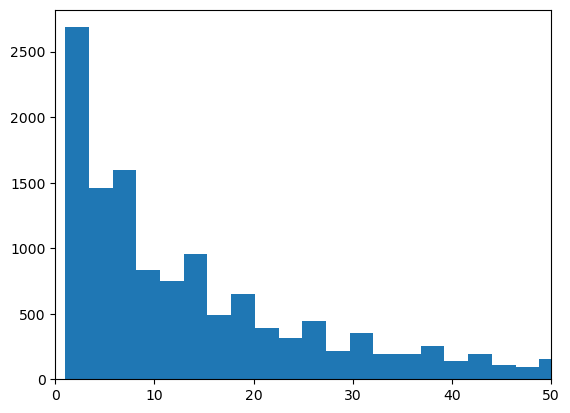

In [25]:
plt.hist(breweries_data['max_nbr_beers'], bins=500)
plt.xlim(0,50)

In [26]:
# Local breweries < 50
# Industrial breweries > 50
breweries_data['Local_brewery'] = breweries_data['max_nbr_beers'].apply(lambda x: True if x < 20 else False)

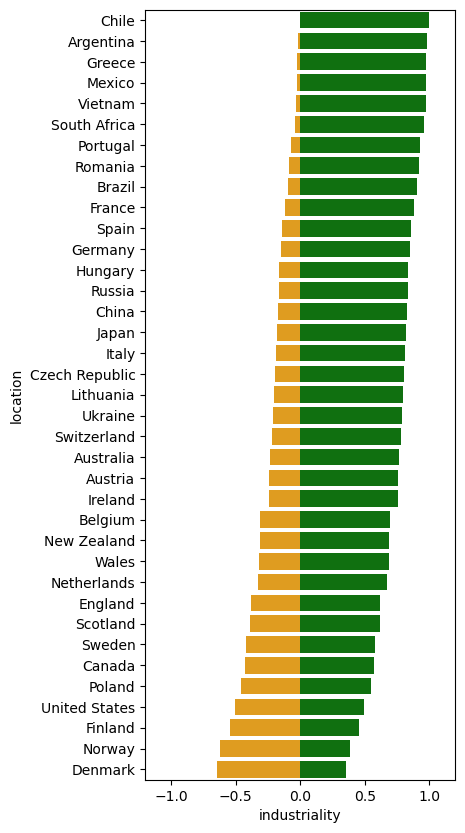

In [28]:
fig, ax = plt.subplots(figsize=(4, 10))

grouped = breweries_data.groupby('location').agg({
    'Local_brewery': lambda x: x.mean(),
    'name': 'size'
}).reset_index()
grouped.sort_values(by='Local_brewery', ascending=False, inplace=True)
grouped['industriality'] = grouped['Local_brewery'] - 1
grouped = grouped[grouped['name'] > 30]

sns.barplot(data=grouped, y='location', x='Local_brewery', color='green')
sns.barplot(data=grouped, y='location', x='industriality', color='orange')

plt.xlim(-1.2,1.2)
plt.show()

In [78]:
grouped = breweries_data.groupby('location').agg({
    'Local_brewery': lambda x: x.mean(),
    'location': 'size'
}).reset_index()
country_to_keep = grouped[grouped[0] > 30]['location']

breweries_data = breweries_data[breweries_data['location'].isin(country_to_keep)]
breweries_data

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim,max_nbr_beers,Local_brewery
17,20776.0,Wales,The Celt Experience,35.0,14338.0,Wales,Celt Experience,116.0,0.455129,0.941499,116.0,False
18,33360.0,Wales,The Handmade Beer Co.,2.0,18262.0,Wales,Handmade Beer Co.,8.0,0.340948,0.914089,8.0,True
19,8412.0,Wales,The Plassey Brewery,6.0,2616.0,Wales,Plassey,24.0,0.526388,0.863596,24.0,True
20,27807.0,Wales,The Untapped Brewing Co.,6.0,11652.0,Wales,Untapped,12.0,0.432760,0.824214,12.0,True
21,31060.0,Wales,The Waen Brewery,17.0,10455.0,Wales,Waen,72.0,0.526388,0.863596,72.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16740,30984.0,"United States, North Carolina",White Rabbit Brewing Company,18.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,True
16748,16233.0,"United States, California",Farmhouse Brewing Co.,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,True
16753,128.0,Germany,Privatbrauerei Franz Joseph Sailer,6.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,True
16755,1573.0,"United States, New York",John Harvard’s Brewery & Ale House,491.0,NaN,NaN,NaN,NaN,NaN,NaN,491.0,False
